<a href="https://colab.research.google.com/github/jerrysdatanote01-collab/Learn-Pytorch/blob/main/Neural_Network_Pytorch_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2024-07-10 03:32:03--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/g2lmp7n22c8q1v1zbv7jp/all.zip?rlkey=armbq1h6tuvxwnze5jxoaopmq [following]
--2024-07-10 03:32:04--  https://www.dropbox.com/scl/fi/g2lmp7n22c8q1v1zbv7jp/all.zip?rlkey=armbq1h6tuvxwnze5jxoaopmq
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48434ab1904b30f8a11d8f225d.dl.dropboxusercontent.com/cd/0/inline/CWa7MVTJPTzjdYeOM1PiBCsPHL0zsSQ-ofoDu8jz2eOF0Fgf5JFgcgf5-ILimVolF6XMg8IC4TqZ-30GRt5tILCI1TRpZbcmMW8NHL2sqkteFFZRkHf4v0yMaILfSKvhbO9sbG2X5XqJQJUBNoFzvAaI/file# [following]
--2024-07-10 03:32:04--  https://uc48434ab1904b30f8a11d8f225d.dl.dropboxusercontent.com/cd/0/inline/CWa7MVTJPTzjd

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from imgaug import augmenters as iaa

In [ ]:
tfm = iaa.Sequential(iaa.Resize(28))

In [ ]:
class XO(Dataset):
  def __init__(self, folder):
    self.files = glob(folder)
  def __len__(self):
    return len(self.files)
  def __getitem__(self, ix):
    f = self.files[ix]
    im = tfm.augment_image(cv2.imread(f)[:,:,0])
    im = im[None]
    cl = f.split('/')[-1].split('@')[0] == 'x'
    return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [ ]:
data = XO('/content/all/*')

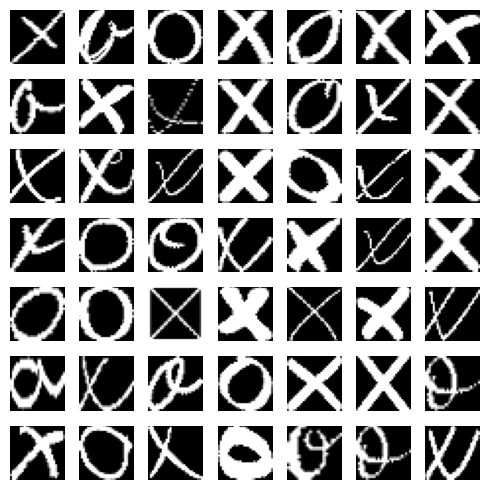

In [ ]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(1000)
    im, label = data[ix]
    print()
    plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [ ]:
from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
      nn.Sigmoid()
      ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass s

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
trn_dl = DataLoader(XO('/content/all/*'),batch_size=32, drop_last=True)

In [ ]:
model, loss_fn, optimizer = get_model()

In [ ]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

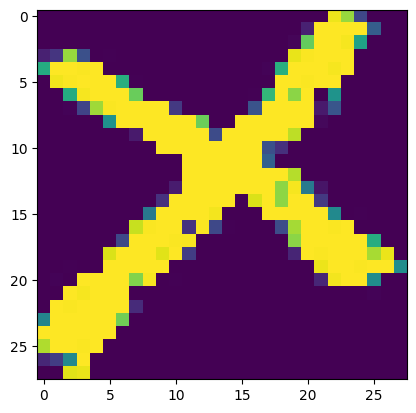

In [ ]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

In [ ]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

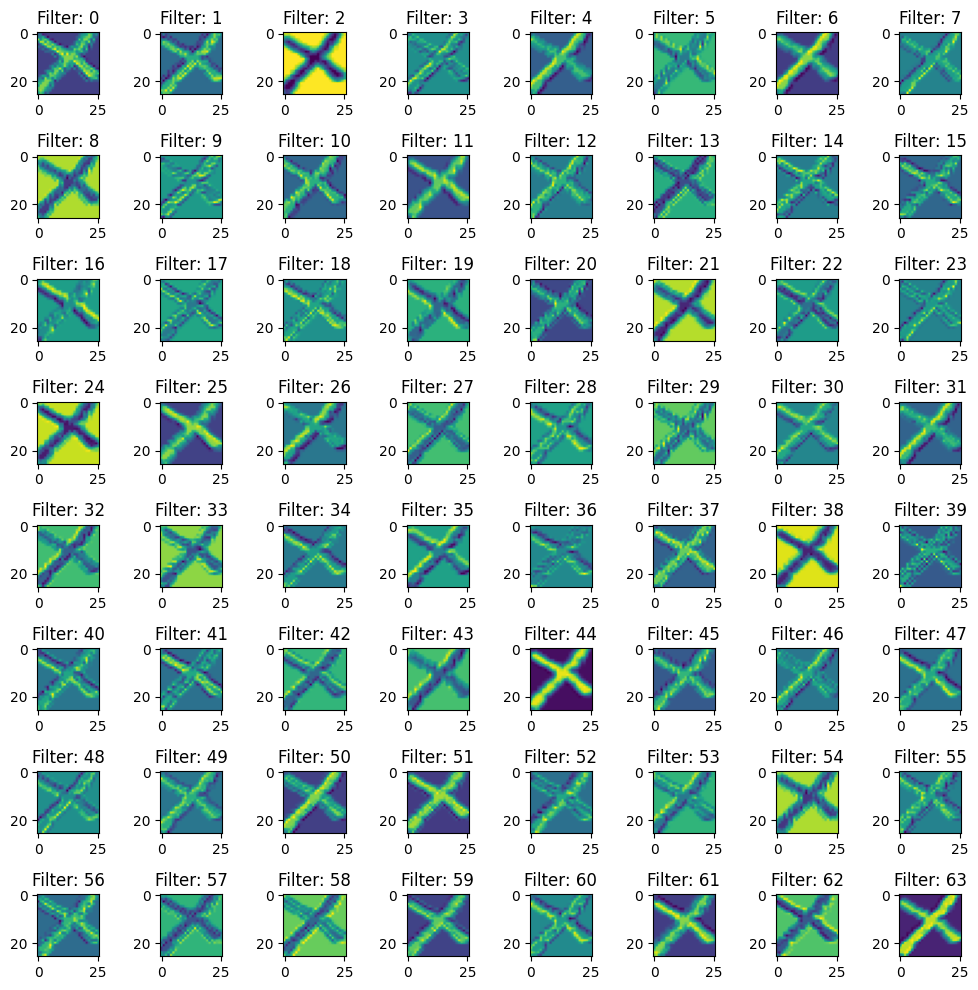

In [ ]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()